In [1]:
import json
import os
from PIL import Image
from pathlib import Path
import cv2
import numpy as np

import logging

logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)

categories = ['LCD', 'odometer']

def via_to_coco(via_json_path, output_path, images_dir_path):
    with open(via_json_path) as f:
        via_data = json.load(f)

    coco_data = {
        "images": [],
        "annotations": [],
        "categories": []
    }

    # categories = []
    # for image_id, item in enumerate(via_data.values(), start=1):
    #     for region in item['regions']:
    #         region_attributes = region['region_attributes']
    #         if region_attributes['identity'] not in categories:
                # categories.append(region_attributes['identity'])
    categories.sort()
    for category_id, category in enumerate(categories, start=1):
        coco_data["categories"].append({"id": category_id, "name": category, "supercategory": None, "isthing": 1})
    print(categories)
    annotation_id = 1
    for image_id, item in enumerate(via_data.values(), start=1):
        image_filename: str = item['filename']
        image_filename = image_filename.split('/')[-1]
        image_size = item['size']
        image_path = os.path.join(images_dir_path, image_filename)

        if os.path.isfile(image_path):
            image = Image.open(image_path)
            width, height = image.size

            coco_data["images"].append({
                "file_name": image_filename,
                "height": height,
                "width": width,
                "id": image_id
            })

            # logger.debug("Image ID: %s", image_id)

            for region in item['regions']:
                shape_attributes = region['shape_attributes']
                all_points_x = shape_attributes['all_points_x']
                all_points_y = shape_attributes['all_points_y']
                segmentation = [list(sum(zip(all_points_x, all_points_y), ()))]
                bbox = [min(all_points_x), min(all_points_y), max(all_points_x) - min(all_points_x), max(all_points_y) - min(all_points_y)]
                try:
                    category_id = categories.index(region['region_attributes']['identity']) + 1
                except ValueError:
                    logger.warning("Category not found: %s", region['region_attributes']['identity'])
                    continue

                coco_data["annotations"].append({
                    "segmentation": segmentation,
                    "bbox": bbox,
                    "area": width * height,
                    "iscrowd": 0,
                    "image_id": image_id,
                    "category_id": category_id,
                    "id": annotation_id
                })

                annotation_id += 1
        else:
            logger.warning("Image not found: %s", image_path)

    with open(output_path, 'w') as f:
        json.dump(coco_data, f)

In [2]:
JSON_PATH = "/home/vamsik1211/Data/git-repos/ClearquoteProject/exercise-2/dataset/train/62a4ff872be4ea4a151632b4/via_region_data.json"
IMAGES_DIR = Path("/home/vamsik1211/Data/git-repos/ClearquoteProject/exercise-2/dataset/train/62a4ff872be4ea4a151632b4")
COCO_PATH = "/home/vamsik1211/Data/git-repos/ClearquoteProject/exercise-2/dataset/train/62a4ff872be4ea4a151632b4/coco_data.json"

In [3]:
via_to_coco(JSON_PATH, COCO_PATH, IMAGES_DIR)

['LCD', 'odometer']


In [5]:
# Generating COCO jsons for all the images in the dataset

ROOT_DIR = Path("/home/vamsik1211/Data/git-repos/ClearquoteProject/exercise-2/dataset/test")

for dir in ROOT_DIR.iterdir():
    if dir.is_dir():
        logger.info("Processing %s", dir)
        via_json_path = dir / "via_region_data.json"
        coco_json_path = dir / "coco_data.json"
        via_to_coco(via_json_path, coco_json_path, dir)

Category not found: M


['LCD', 'odometer']
['LCD', 'odometer']
['LCD', 'odometer']


In [5]:
from pycocotools import coco, cocoeval, _mask
from pycocotools import mask as maskUtils
from PIL import  Image
from matplotlib import pyplot as plt

In [7]:
annotations = coco.COCO("dataset/train/62a4ff872be4ea4a151632b4/coco_data.json")

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


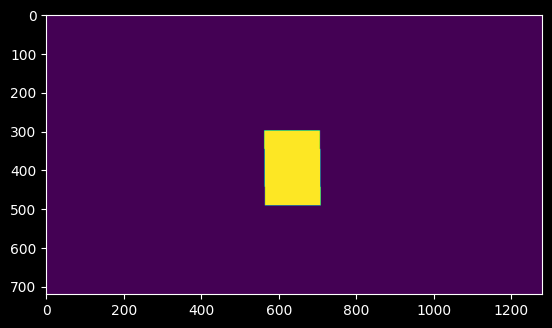

In [8]:
# plt.imshow(annotations.annToMask(annotations.anns[1]))
plt.imshow(annotations.annToMask(annotations.anns[80]))

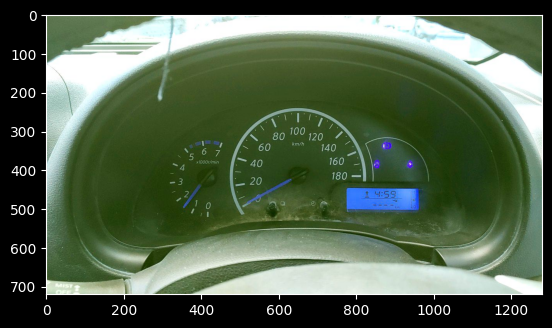

In [9]:
plt.imshow(cv2.imread(str(IMAGES_DIR / annotations.imgs[80]["file_name"])))


# annotations.imgs[3]


In [10]:
image_ids = annotations.getImgIds()
images = annotations.loadImgs(image_ids)

image_attributes = images[79]

image_ann_ids = annotations.getAnnIds(imgIds=image_attributes['id'])
# image = Image.open(IMAGES_DIR / image_attributes['file_name'])
image = cv2.imread(str(IMAGES_DIR / image_attributes['file_name']))
image_ann_ids = annotations.getAnnIds(imgIds=image_attributes['id'])
image_anns = annotations.loadAnns(image_ann_ids)

image_anns, image_ann_ids

([], [])

In [15]:
image_attributes

{'file_name': 'scraped_LqzIOp_1654870319508.jpg',
 'height': 720,
 'width': 1280,
 'id': 80}

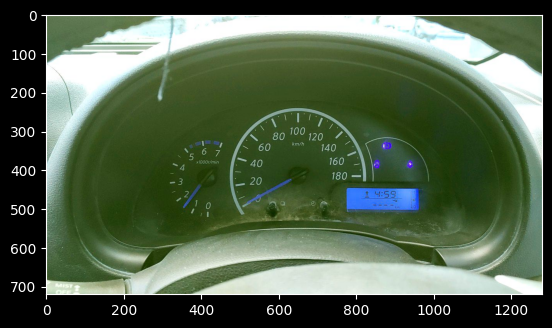

In [12]:
for ann in image_anns:
    cv2.rectangle(image, (ann['bbox'][0], ann['bbox'][1]), (ann['bbox'][0] + ann['bbox'][2], ann['bbox'][1] + ann['bbox'][3]), (255, 0, 0), 2)
    mask = annotations.annToMask(ann)
    mask = np.dstack([mask] * 3)*128
    image = cv2.addWeighted(image, 0.5, mask, 0.5, 0, image)

plt.imshow(image)

In [14]:
mask

NameError: name 'mask' is not defined

In [13]:
plt.imshow(mask)

NameError: name 'mask' is not defined

In [96]:
annotations.loadCats(2)

[{'id': 2, 'name': 'odometer', 'supercategory': None, 'isthing': 1}]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


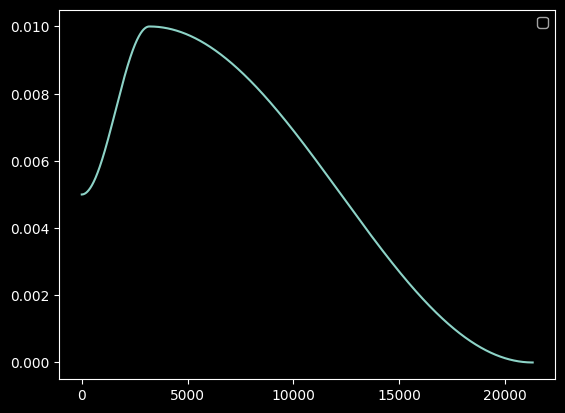

In [68]:
from matplotlib import pyplot as plt
import torch
from torchvision.models.squeezenet import  squeezenet1_1, SqueezeNet1_1_Weights

model = squeezenet1_1(weights=SqueezeNet1_1_Weights.DEFAULT)

EPOCHS = 100
BATCHES = 213
steps = []
lrs = []
mtms = []
# model = ... # Your model instance
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9) # Wrapped optimizer
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, pct_start=0.15, div_factor=2, final_div_factor=100000, base_momentum=0.75, max_momentum=0.95, epochs=EPOCHS, steps_per_epoch=BATCHES)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200, eta_min=0.00001)
# scheduler = torch.optim.lr_scheduler.PolynomialLR(optimizer, total_iters=EPOCHS*BATCHES, power=3.5, last_epoch=-1)
for epoch in range(EPOCHS):
    for batch in range(BATCHES):
        scheduler.step()
        lrs.append(scheduler.get_last_lr()[0])
        mtms.append(optimizer.param_groups[0]['momentum'])
        steps.append(epoch * BATCHES + batch)

plt.figure()
plt.legend()
plt.plot(steps, lrs, label='OneCycle')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


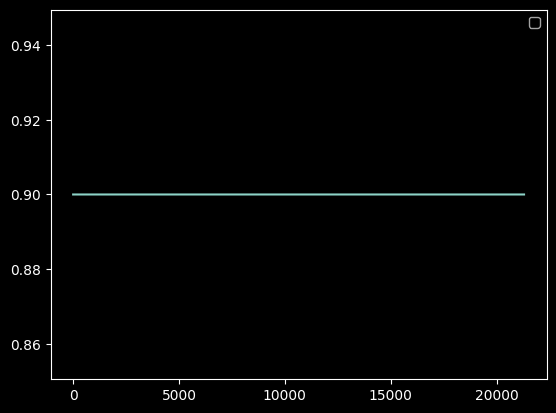

In [44]:
plt.figure()
plt.legend()
plt.plot(steps, mtms, label='OneCycle')
plt.show()